In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random 
from multiprocessing import Pool
import math

In [3]:
from tqdm.notebook import tqdm

In [4]:
CID = '01350804'
x = float(CID[len(CID)-3])
y = float(CID[len(CID)-2])
z = (float(CID[len(CID)-1])+1) % 3 + 1

p_cid = 0.25 + 0.5 * (x+1)/10
gamma_cid = 0.2 + 0.5 * y/10


In [6]:
class GridWorld(object):

    def __init__(self, p=p_cid):
        
        ### Attributes defining the Gridworld #######
        self.p = p
        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(3,1),(4,1),(4,2),(2,3),(2,5),(4,4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1,3),(4,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = self.get_random_loc()
        
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = np.array([p, (1-p)/3, (1-p)/3, (1-p)/3])
        self.action_randomizing_transition_matrix = np.array([np.roll(self.action_randomizing_array, i) for i in range(4)])
        
        ############################################
    

        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 22 of them - 5x5 grid minus obstacles)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs)
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)))
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape)
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        # self.paint_maps()

        ################################
    
    

    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R

    def get_p(self):
        return self.p
    
    ########################


    
    ####### Methods #########
    
    def value_iteration(self, discount = gamma_cid, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0, state_idx]):
                  
                    # Store the previous value for that state
                    v = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[state_idx]))
            

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
             
            # Compute Q value
            Q = np.zeros(4)
            for state_idx_prime in range(self.state_size):
                Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
            
            # The action that maximises the Q value gets probability 1
            optimal_policy[state_idx, np.argmax(Q)] = 1 

        return optimal_policy, epochs


    
    def policy_iteration(self, discount=gamma_cid, threshold = 0.0001):
        ## Slide 139 of the lecture notes for pseudocode ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop

        while not(policy_stable): 

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval # Increment epoch

            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                    
                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])
                
                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        for action in range(4):
                            Q[action] += T[state_idx_prime][state_idx][action] * (R[state_idx_prime][state_idx][action] + discount * V[state_idx_prime])

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                
                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False
            
        return V, policy, epochs
                
        
    
    def policy_evaluation(self, policy, threshold = 0.0001, discount = gamma_cid):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime, state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            # Note: The below is our example way of computing delta.
            #       Other stopping criteria may be used (for instance mean squared error).
            #       We encourage you to explore different ways of computing delta to see 
            #       how it can influence outcomes.
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch

    ##########################
        
        
        
        

    ########### Internal Drawing Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##


    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        #plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        #plt.show()

    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        #plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        #plt.show()


   

    ##########################
    
    
    ########### Internal Helper Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##

    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()
        

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
                # Fill the transition matrix:
                # A good way to understand the code, is to first ask ourselves what the structure 
                # of the transition probability ‘matrix’ should be, given that we have state, successor state and action. 
                # Thus, a simple row x column matrix of successor state and will not suffice, as we also have to condition 
                #  on the action. So we can therefore choose to implement this to  have a structure that is 3 dimensional
                # (technically a tensor, hence the variable name T). I would not worry too much about what a tensor is, 
                # it is simply an array that takes 3 arguments to get a value, just like conventional matrix is an array that
                # takes 2 arguments (row and column), to get a value. To touch all the elements in this structure we
                # need therefore to loop over states and actions.
                                # [0.5, 0.5/3, 0.5/3. 0.5/3]
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         


    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()



    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()
        
        

            
    def get_random_loc(self):
        return random.choice(list(filter(
            lambda x: x not in self.obstacle_locs and x not in self.absorbing_locs, 
            [(i,j) for i in range(6) for j in range(6)])))
    

    def generate_trace(self, policy):
        locations, neighbours, absorbing = self.get_topology()
        R = self.get_reward_matrix()

        # get random starting location
        self.starting_loc = self.get_random_loc()

        state_index = self.loc_to_state(self.starting_loc, self.locs)
        trace = []

        while True: 
            if state_index in absorbing[0].nonzero()[0]:
                return trace
            
            action = random.choices([0,1,2,3], policy[state_index])
            effect_probability = self.action_randomizing_transition_matrix[action][0]
            effect = random.choices([0,1,2,3], effect_probability)[0]
            
            destination_index = int(neighbours[state_index][effect])
            trace.append((state_index, ["N", "E", "S", "W"][effect], R[destination_index][state_index][effect]))
            state_index = destination_index
    
    
    def apply_e_greedy_Q(self, Q, epsilon):
        _, neighbours, _ = self.get_topology()
        new_policy = np.full((self.state_size, self.action_size),epsilon/self.action_size)
        immediate_reward=np.full(self.state_size, self.default_reward)
        
        for i in range(len(self.absorbing_locs)):
            immediate_reward[self.loc_to_state(self.absorbing_locs[i],self.locs)]=self.special_rewards[i]
            
        for state_idx in range(self.state_size): 
            immediate_rewards = [immediate_reward[int(neighbour)] for neighbour in neighbours[state_idx]]
            value_of_neighbours = list([Q[state_idx][j]+immediate_rewards[j] for j in range(len(immediate_rewards))])
            new_policy[state_idx, np.argmax(value_of_neighbours)] = 1 - epsilon + epsilon/self.action_size
        return new_policy
    
    def calculate_trace_reward(self,trace):
        np_trace = np.array(trace)
        rewards = np.asarray(np_trace[:,2], dtype=np.float32)
        total = rewards.sum()
        return total
        
    def Q2V(self, Q, epsilon=0):
        Vs=[]
        for s in range(self.state_size):
            V = (1-epsilon)*max(Q[s]) +(epsilon*np.sum(Q[s]))/self.action_size
            Vs.append(V)
        return np.array(Vs)
        
    ##########################################
    #################################
    ############################################
    ##############################################

    
    def MC_evaluation(self, policy, episodes, discount = gamma_cid):
        Returns = [[None for a in range(grid.action_size)] for s in range(self.state_size)]
       
        for ep in range(episodes):
            G=0
            trace = self.generate_trace(policy) #new trace from new starting loc every episode
            trace_reward = self.calculate_trace_reward(trace)
            seen_pairs = np.ones((self.state_size, self.action_size))
            for step in trace[::-1]:
                G = discount * G + float(step[2])
                
                action_idx = self.action_names.index(step[1])
                if seen_pairs[step[0],action_idx]>0:
                    Returns[step[0]][action_idx] = G
                    seen_pairs[step[0],action_idx] = 0
        return Returns, trace_reward
    
    
    def MC_batch(self, episodes, batches=1, epsilon=0, gamma=gamma_cid):
        #initialisation
        Q = np.zeros((self.state_size,self.action_size))
        Q[:,0]=1
        policy = self.apply_e_greedy_Q(Q,epsilon=epsilon)
        #End initialisation
        #######
        all_Returns = []
        total_reward = []
        #For each batch
        for batch in range(batches):
            Returns = [[None for a in range(grid.action_size)] for s in range(self.state_size)]
       
            for ep in range(episodes):
                G=0
                trace = self.generate_trace(policy) #new trace from new starting loc every episode
                trace_reward = self.calculate_trace_reward(trace)
                total_reward.append(trace_reward)
                seen_pairs = np.ones((self.state_size, self.action_size))
                for step in trace[::-1]:
                    G = gamma * G + float(step[2])

                    action_idx = self.action_names.index(step[1])
                    if seen_pairs[step[0],action_idx]>0:
                        Returns[step[0]][action_idx] = G
                        seen_pairs[step[0],action_idx] = 0
            #batch_Returns, trace_reward = self.MC_evaluation(policy = greedy_applied_PolicyQ, episodes = episodes, discount = gamma)
            all_Returns.append(Returns.copy())
        
            for s in range(self.state_size):
                for a in range(self.action_size):
                    state_action_pair_values = []
                    for batch_idx in range(len(all_Returns)):
                        if all_Returns[batch_idx][s][a] != None:
                            state_action_pair_values.append(all_Returns[batch_idx][s][a])

                    if len(state_action_pair_values) != 0:
                        Q[s][a] = sum(state_action_pair_values)/len(state_action_pair_values)

            policy = self.apply_e_greedy_Q(Q,epsilon)
        
        V = np.average(Q, axis=1)
        
        return V, Q, policy, total_reward
    
    
    
    def MC_Iterative(self, iterations, alpha, epsilon=0, update_epsilon=False, gamma=gamma_cid):
        #initialisation
        initial_epsilon = epsilon
        Q = np.zeros((self.state_size,self.action_size))
        Q[:,0]=1
        greedy_applied_PolicyQ = self.apply_e_greedy_Q(Q,epsilon=epsilon)
        #End initialisation
        total_reward = []
        Vs = []
        #for i in tqdm(range(iterations)):
        for i in range(iterations):
            R = 0
            trace = self.generate_trace(greedy_applied_PolicyQ)
            total_reward.append(self.calculate_trace_reward(trace))
            
            seen_pairs = np.ones((self.state_size, self.action_size))
            for step in trace[::-1]:
                action_idx = self.action_names.index(step[1])
                if seen_pairs[step[0],action_idx]>0:
                    R = gamma*R + float(step[2])
                    Q[step[0]][action_idx] = Q[step[0]][action_idx] + alpha*(R - Q[step[0]][action_idx])
                    seen_pairs[step[0],action_idx] = 0
            if update_epsilon:     
                epsilon = initial_epsilon*(math.exp(-i/400))
            greedy_applied_PolicyQ = self.apply_e_greedy_Q(Q, epsilon)
            V = self.Q2V(Q, epsilon)
            Vs.append(V)
          
        return Vs, Q, greedy_applied_PolicyQ, np.asarray(total_reward, dtype=np.float32)
            
            

    
    def SARSA(episodes, alpha, epsilon=0, gamma=gamma_cid):
        R = self.get_reward_matrix()
        locations, neighbours, absorbing = self.get_topology
        
        
        Q = np.random.rand(self.state_size, self.action_size)
        for loc in self.absorbing_locs:
            Q[self.loc_to_state(loc,self.locs)]=0
            
        for ep in range(epidodes):
            self.init_state = self.get_random_loc()
            state_index = self.loc_to_state(self.starting_loc, self.locs)
            
            total_reward = 0
            policy = self.apply_e_greedy_Q(Q, epsilon=epsilon)
            action = random.choices([0,1,2,3], policy[state_idx])[0]
            
            while True:
                if state_index in absorbing[0].nonzero()[0]:
                    total_rewards.append(total_reward)
                    break
                    
                effect_probability = self.action_randomizing_transition_matrix[action][0]
                effect = random.choices([0,1,2,3], effect_probability)[0]
            
                destination_index = int(neighbours[state_index][effect])
                trace.append((state_index, ["N", "E", "S", "W"][effect], R[destination_index][state_index][effect]))
                
                reward = R[destination_index][state_index][effect]
                total_reward = total_reward * gamma + reward
                
                
                policy = self.apply_e_greedy_Q(Q, epsilon=epsilon)
                action_index_prime = random.choices([0,1,2,3], policy[destination_idx])[0]
                
                Q[state_index][action_index] = Q[state_index][action_index] + alpha * (reward + g * Q[destination_index][action_index_prime] - Q[state_index][action_index])
                    
                state_index = destination_index
                action_index= action_index_prime
            
            return Q, np.array[total_rewards]
                
                
            

# Dynamic Programming

In [12]:
val_opt =[-1.19489879e+00, -1.08210311e+00,  5.00613973e-02,  7.11898864e+00,
        5.99101363e-02, -5.47246452e-01, -1.22250194e+00,  7.41870457e+00,
        0.00000000e+00,  7.14752293e+00, -2.08799109e-01, -1.22873864e+00,
       -1.10011299e+00,  1.18390037e-02,  2.82621302e-02, -1.23518361e+00,
       -1.37777872e+00, -1.34230114e+01, -1.31129950e+00, -1.25021071e+00,
       -1.23331120e+00,  0.00000000e+00, -1.24722659e+00, -1.22889984e+00,
       -1.22262067e+00, -1.38973901e+00, -6.08980840e+00, -1.54336562e+00,
       -1.25129350e+00]

In [13]:
policy_opt = np.array([[0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.99382821, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726],
       [0.00205726, 0.00205726, 0.00205726, 0.99382821],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.00205726, 0.00205726, 0.99382821, 0.00205726],
       [0.99382821, 0.00205726, 0.00205726, 0.00205726]])

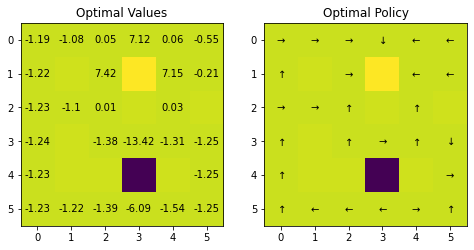

In [14]:
grid = GridWorld()
V_opt_DP, pol_opt, epochs = grid.policy_iteration(discount=gamma_cid)
plt.figure(1, figsize = (8,4))
plt.subplot(1,2,1)
plt.title('Optimal Values')
grid.draw_value(val_opt)

pol_opt_deterministic=[np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]
plt.figure(1)
plt.subplot(1,2,2)
grid.draw_deterministic_policy(pol_opt_deterministic)
plt.title('Optimal Policy')
plt.show()

In [48]:
#file = 'Dynamic'
#with open(file, 'wb') as f:
#    pickle.dump(V_opt_DP, f)
#    f.close()
#    print('saved')

NameError: name 'graph' is not defined

In [8]:
### part 4:
def policy_iteration_grid(grid_in, gamma=gamma_cid):
        V_opt, pol_opt, epochs = grid_in.policy_iteration(discount=gamma)
        return (V_opt, [np.argmax(pol_opt[row,:]) for row in range(grid.state_size)], f"g={gamma}, p={grid_in.get_p()}")

probs = [0.1, 0.25, 0.4, 0.55]
gammas = [0.3, 0.7]
values = []
policies = []
titles = []


for gamma in gammas:        
        for prob in probs:
                grid = GridWorld(p=prob)
                value, policy, title = policy_iteration_grid(grid, gamma=gamma)
                values.append(value)
                policies.append(policy)
                titles.append(title)


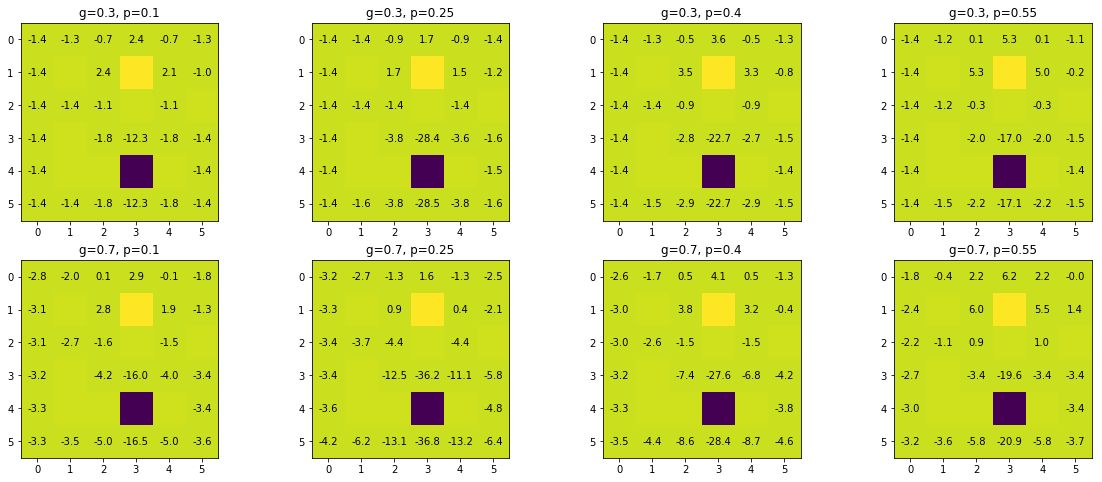

In [9]:
grid.draw_value_grid(values , titles,len(gammas),len(probs) )

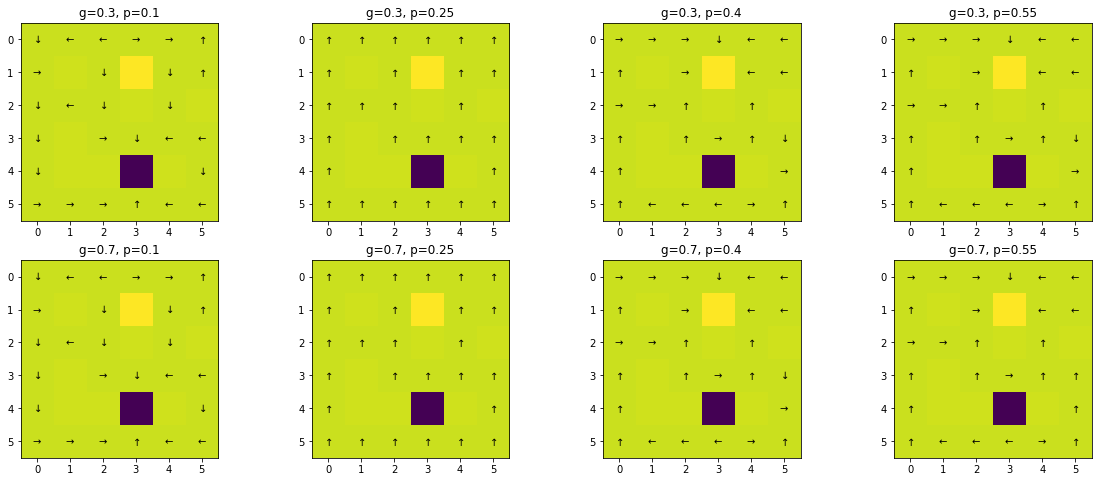

In [10]:
grid.draw_deterministic_policy_grid(policies, titles, len(gammas), len(probs))

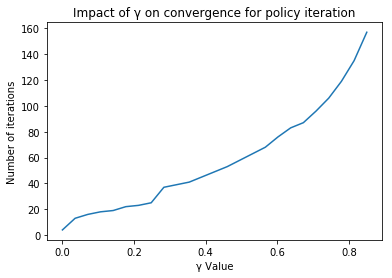

In [25]:
gamma_range = np.linspace(0,0.85,25)
epochs_needed = []
grid = GridWorld()
# Use policy evaluation for each gamma value
for gamma in gamma_range:
    _, _, epochs = grid.policy_iteration(discount=gamma)
    epochs_needed.append(epochs)

# Plot the number of epochs vs gamma values
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("γ Value")
plt.ylabel("Number of iterations")
#plt.grid(b=True, color='y')
#plt.legend(('Value iteration','Policy iteration')) 
plt.title('Impact of γ on convergence for policy iteration')
plt.show()


## MONTE CARLO 

In [12]:
#Batch Learning
###################
grid = GridWorld()
estimated_Values, mc_q, mc_policy, total_rewards = grid.MC_batch(episodes=60, batches=50, epsilon = 0.05)

In [14]:
repetitions = 200
episodes=10
batches=40

In [48]:
grid = GridWorld()

epsilon = 0.05
Average = np.zeros(episodes*batches)
for rep in tqdm(range(repetitions)):
    _,_,_, total_rewards = grid.MC_batch(episodes=episodes, batches=batches, epsilon = epsilon)
    Average += total_rewards
Average = Average/repetitions


In [49]:

epsilon = 0.25
Average_2 = np.zeros(episodes*batches)
for rep in tqdm(range(repetitions)):
    _,_,_, total_rewards = grid.MC_batch(episodes=episodes, batches=batches, epsilon = epsilon)
    Average_2 += total_rewards
Average_2 = Average_2/repetitions

<function matplotlib.pyplot.show(*args, **kw)>

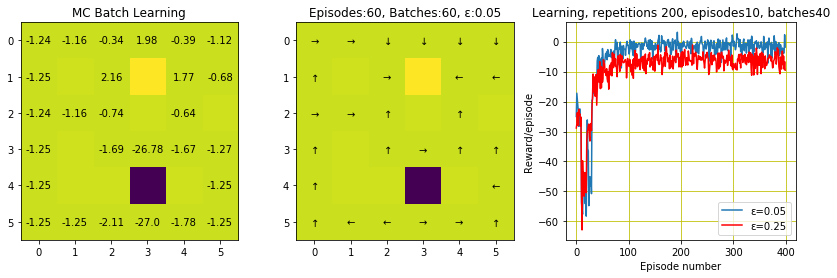

In [51]:
x_size = 14
plt.figure(1, figsize = (x_size,4))
plt.subplot(1,3,1)
grid.draw_value(estimated_Values)
plt.title('MC Batch Learning')
plt.figure(1, figsize = (x_size,4))
plt.subplot(1,3,2)
grid.draw_deterministic_policy(np.argmax(mc_policy,axis=1))
strtitle='Episodes:{}, Batches:{}, ε:{}'.format(60,60,0.05)
plt.title(strtitle)
#plt.show
plt.figure(1, figsize = (x_size,4))
plt.subplot(1,3,3)
x_axis = np.arange(0,episodes*batches)
plt.plot(x_axis,Average)
plt.plot(x_axis,Average_2,color='r')
plt.xlabel("Episode number")
plt.ylabel("Reward/episode")
plt.grid(b=True, color='y')
plt.legend(('ε=0.05','ε=0.25')) 
plt.title('Learning, repetitions {}, episodes{}, batches{}'.format(200,10,40))
plt.show

In [15]:
grid = GridWorld()
repetitions=200
iterations=400

In [9]:
#####Iterative#####  def MC_Iterative(self, iterations, alpha, update_alpha=True,epsilon=0, gamma=gamma_cid)
###################



All_rewards_noUpdate=[]
for rep in range(repetitions):
    _, _, _, total_reward = grid.MC_Iterative(iterations,0.2,False,0.1)
    All_rewards_noUpdate.append(total_reward.copy())
    print(rep)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [10]:
All_rewards_update_1=[]
for rep in range(repetitions):
    _, _, _, total_reward = grid.MC_Iterative(iterations,0.2,True,0.05)
    All_rewards_update_1.append(total_reward.copy())
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [11]:
All_rewards_update_2=[]
for rep in range(repetitions):
    _, _, _, total_reward = grid.MC_Iterative(iterations,0.2,True,0.25)
    All_rewards_update_2.append(total_reward.copy())
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [20]:


import pickle
with open('MCITER', 'wb') as f:
    pickle.dump([All_rewards_noUpdate,All_rewards_update_1,All_rewards_update_2], f)

In [46]:
import pickle

In [9]:
All_Rewards = pickle.load(open('MCITER','rb'))

In [44]:
from sklearn.metrics import mean_squared_error

In [25]:
mean_noUpdate = np.mean(np.asarray(All_Rewards[0], dtype=np.float32),axis = 0)
mean_update_1 = np.mean(np.asarray(All_Rewards[1], dtype=np.float32),axis = 0)
mean_update_2 = np.mean(np.asarray(All_Rewards[2], dtype=np.float32),axis = 0)
std_noUpdate = np.mean(np.asarray(All_Rewards[0], dtype=np.float32),axis = 0)


In [45]:
grid = GridWorld()
mse_mcI_noUpdate=[]
V, _, _, _ = grid.MC_Iterative(iterations,0.2,False,0.1)
for it in range(iterations):
    mse_mcI_noUpdate.append(mean_squared_error(V[it],V_opt_DP, squared=False))

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

<function matplotlib.pyplot.show(*args, **kw)>

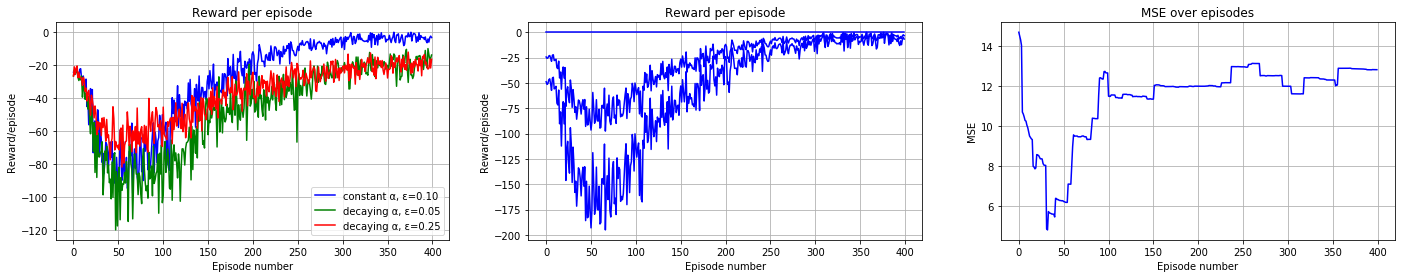

In [41]:
x_size = 24
plt.figure(2, figsize = (x_size,4))
plt.subplot(1,3,1)
x_axis = np.arange(0,iterations)
plt.plot(x_axis,mean_noUpdate, color = 'b')
plt.plot(x_axis,mean_update_1, color = 'g')
plt.plot(x_axis,mean_update_2, color = 'r')
plt.xlabel("Episode number")
plt.ylabel("Reward/episode")
plt.grid(b=True)
plt.legend(('constant α, ε=0.10','decaying α, ε=0.05','decaying α, ε=0.25'))
#plt.legend(('Value iteration','Policy iteration')) 
plt.title('Reward per episode')

plt.figure(2, figsize = (x_size,4))
plt.subplot(1,3,2)
plt.plot(x_axis,mean_noUpdate, color = 'b')
plt.plot(x_axis,mean_noUpdate+std_noUpdate, color = 'b')
plt.plot(x_axis,mean_noUpdate-std_noUpdate, color = 'b')
plt.xlabel("Episode number")
plt.ylabel("Reward/episode")
plt.grid(b=True)
plt.title('Reward per episode')

plt.figure(2, figsize = (x_size,4))
plt.subplot(1,3,3)
plt.plot(x_axis,mse_mcI_noUpdate, color = 'b')
plt.xlabel("Episode number")
plt.ylabel("MSE")
plt.grid(b=True)
plt.title('MSE over episodes')

plt.show

In [19]:
plt.figure(3, figsize = (8,4))
plt.subplot(1,2,1)
grid.draw_value(V)
plt.figure(3, figsize = (8,4))
plt.subplot(1,2,2)
grid.draw_deterministic_policy(np.argmax(polgreedy_applied_PolicyQ,axis=1))
plt.show

NameError: name 'V' is not defined

# TD